In [1]:
%matplotlib inline
import os
import re
import io

import matplotlib
import numpy as np
import pandas as pd
import xarray as xr

import climatools.html.html as climahtml
import climatools.lblnew.g1_threshold as scripts

import IPython.display as display

import imp
imp.reload(scripts)

/chia_cluster/home/jackyu/anaconda3/lib/python3.6/site-packages/matplotlib/__init__.py:1405: UserWarning: 
This call to matplotlib.use() has no effect because the backend has already
been chosen; matplotlib.use() must be called *before* pylab, matplotlib.pyplot,
or matplotlib.backends is imported for the first time.

  warnings.warn(_use_error_msg)
/chia_cluster/home/jackyu/anaconda3/lib/python3.6/site-packages/matplotlib/__init__.py:1405: UserWarning: 
This call to matplotlib.use() has no effect because the backend has already
been chosen; matplotlib.use() must be called *before* pylab, matplotlib.pyplot,
or matplotlib.backends is imported for the first time.

  warnings.warn(_use_error_msg)


<module 'climatools.lblnew.g1_threshold' from '/chia_cluster/home/jackyu/climatools/climatools/lblnew/g1_threshold.py'>

In [2]:
%run param.py

In [3]:
NG_REFS = PARAM['ng_refs']
P_REFS, T_REFS = zip(*PARAM['ref_pts'])

In [4]:
# for printing some input parameters

def innames():
    return ['vstar', 'nband', 'nv', 'dv',
            'flgh2o',
            'tsfc',
            'pressure_reference_1',
            'temperature_reference_1', 
            'pressure_reference_2', 
            'temperature_reference_2',
            'ighigh', 
            'ng', 
            'nref',
            'p_refs',
            't_refs',
            'ng_refs',
            'ng_adju',
            'absth',
            'wgt',
            'option_wgt_flux',
            'option_wgt_k',
            'option_klin',
            'w_diffuse',
            'fac_meank',
            'klin',
            'option_compute_ktable',
            'option_compute_btable',
            'conc']



def pattern_assign(name):
    return ''' 
    parameter .* :: \s* &? \s* ({} \s* = .* \n)
    '''.format(name)

def pattern_data(name):
    return '''
    (data [^/{name}]+ {name}[^,] [^/{name}]+ / [^/]+ /)
    '''.format(name=name)

def pattern_atmpro():
    return '''
    (atmosphere_profiles/.*75_r8.pro)
    '''
    

def get_input_params(code, names):
    results = []
    for name in names:
        regex = re.compile(pattern_assign(name), re.VERBOSE)
        results.extend(regex.findall(code))
        
        regex = re.compile(pattern_data(name), re.VERBOSE)
        results.extend(regex.findall(code))
        
    regex = re.compile(pattern_atmpro(), re.VERBOSE)
    results.extend(regex.findall(code))
        
    results = [result.replace('_r8', '') for result in results]
    return results


In [5]:
analysis = scripts.Analysis()

In [6]:
crd = analysis.model('crd')
crd.type_model = 'crd'
crd.rundir = DIR_FORTRAN
crd.fpath_flux = 'output_fluxg.dat'
crd.fpath_coolr = 'output_coolrg.dat'
crd.linestyle = '-'
crd.color = 'b'
crd.marker = None
crd.load_data()

In [7]:
def add_wgt_models():
    iggs = [10, 1]
    markers = [None, 'x']
    colors = ['r', 'c']
    linestyle = '-'

    df_wfluxg = pd.read_csv(os.path.join(crd.rundir, 
                                         'output_wfluxg.dat'), 
                            sep=r'\s+')

    df_wcoolrg = pd.read_csv(os.path.join(crd.rundir, 
                                          'output_wcoolrg.dat'), 
                             sep=r'\s+')

    for igg, marker, color in zip(iggs, markers, colors):

        flux_igg = df_wfluxg[df_wfluxg['igg'] == igg]\
        .drop('igg', axis=1)
        s_flux = io.StringIO(flux_igg.to_csv(sep=' '))

        coolr_igg = df_wcoolrg[df_wcoolrg['igg'] == igg]\
        .drop('igg', axis=1)
        s_coolr = io.StringIO(coolr_igg.to_csv(sep=' '))

        crdx_igg = analysis.model('wgt_igg{}'.format(igg))
        crdx_igg.type_model = 'crd'
        crdx_igg.rundir = DIR_FORTRAN
        crdx_igg.fpath_flux = s_flux
        crdx_igg.fpath_coolr = s_coolr
        crdx_igg.color = color
        crdx_igg.marker = marker
        crdx_igg.linestyle = linestyle
        crdx_igg.load_data()
        
add_wgt_models()

In [8]:
def add_ktable_models():
    iggs = [10]
    markers = ['D',]
    color = 'g'
    linestyle = ':'

    df_wwfluxg = pd.read_csv(os.path.join(crd.rundir, 
                                          'output_wwfluxg.dat'), 
                             sep=r'\s+')

    df_wwcoolrg = pd.read_csv(os.path.join(crd.rundir, 
                                           'output_wwcoolrg.dat'), 
                              sep=r'\s+')

    for igg, marker in zip(iggs, markers):

        flux_igg = df_wwfluxg[df_wwfluxg['igg'] == igg]\
        .drop('igg', axis=1)
        s_flux = io.StringIO(flux_igg.to_csv(sep=' '))

        coolr_igg = df_wwcoolrg[df_wwcoolrg['igg'] == igg]\
        .drop('igg', axis=1)
        s_coolr = io.StringIO(coolr_igg.to_csv(sep=' '))

        crdxx_igg = analysis.model('ktable_igg{}'.format(igg))
        crdxx_igg.type_model = 'crd'
        crdxx_igg.rundir = DIR_FORTRAN
        crdxx_igg.fpath_flux = s_flux
        crdxx_igg.fpath_coolr = s_coolr
        crdxx_igg.color = color
        crdxx_igg.marker = marker
        crdxx_igg.linestyle = linestyle
        crdxx_igg.load_data()
        
        

In [9]:
fig = analysis.fig_fluxcoolr('fig1', vartypes=['cooling rate'])
fig.ggroups = list(crd.data['dgdgs'].coords['g'].values) #list(range(1, 8 + 1))
fig.vars_plot['flux'] = ['flug', 'fnetg']
fig.vars_plot['cooling rate'] = ['coolrg']
fig.colors['flug'] = 'darkred'
fig.colors['fnetg'] = 'lightcoral'
fig.colors['coolrg'] = 'blue'
fig.varlims_from_indexrange['linear'] = (50, 1050)
fig.varlims_from_indexrange['log'] = (1e-2, 200)

fig.set_pressure_displayrange(low=1e-2)

In [10]:
table_fluxg = analysis.table('table_fluxg')
table_fluxg.sumg = False
table_fluxg.vartype = 'flux'
table_fluxg.at_pressures = crd.data['flux']\
                             .coords['pressure']\
                             .isel(pressure=[0, -1])

table_coolrg = analysis.table('table_coolrg')
table_coolrg.vartype = 'cooling rate'
table_coolrg.sumg = False
table_coolrg.at_pressures = crd.data['cooling rate']\
                               .coords['pressure']\
                               .isel(pressure=[0, -1])


In [11]:
table_flux = analysis.table('table_flux')
table_flux.sumg = True
table_flux.vartype = 'flux'
table_flux.at_pressures = crd.data['flux']\
                             .coords['pressure']\
                             .isel(pressure=[0, -1])

table_coolr = analysis.table('table_coolr')
table_coolr.vartype = 'cooling rate'
table_coolr.sumg = True
table_coolr.at_pressures = crd.data['cooling rate']\
                              .coords['pressure']\
                              .isel(pressure=[0, -1])

In [12]:
table_dgdgs = analysis.table('dgdgs')
table_dgdgs.vartype = 'dgdgs'
table_dgdgs.sumg = False

In [13]:
for name, value in sorted(PARAM.items()):
    print('{} = {}'.format(name, value))

atmpro = mls
band = 7
commitnumber = a22ab94
conc = 3.2e-07
dv = 0.001
klin = 2.22e-20
molecule = n2o
ng_adju = [0]
ng_refs = [5]
nv = 1000
option_compute_btable = 0
option_compute_ktable = 0
option_wgt_flux = 1
option_wgt_k = 1
ref_pts = [(50, 250)]
tsfc = 294
vmax = 1380
vmin = 1215
w_diffuse = [(1.66, 1.66, 1.66, 1.66, 1.66)]
wgt = [(0.6, 0.7, 0.7, 0.8, 1)]


In [14]:
fig.display_hrefanchor()

In [15]:
table_fluxg.display_hrefanchor()
table_coolrg.display_hrefanchor()

table_flux.display_hrefanchor()
table_coolr.display_hrefanchor()

In [16]:
table_dgdgs.display_hrefanchor()

In [17]:
s_abscom = 'Overall absth'
display.HTML(climahtml.getHTML_hrefanchor(s_abscom))

In [18]:
s_ggroup_summary = 'g-group summary'
display.HTML(climahtml.getHTML_hrefanchor(s_ggroup_summary))

In [19]:
#for g in range(1, 20 + 1):
#    s = 'Table: cooling rate. g-group {}'.format(g)
#    html = climahtml.getHTML_hrefanchor(s)
#    display.display(display.HTML(html))

# Figure: cooling rate g-group 1

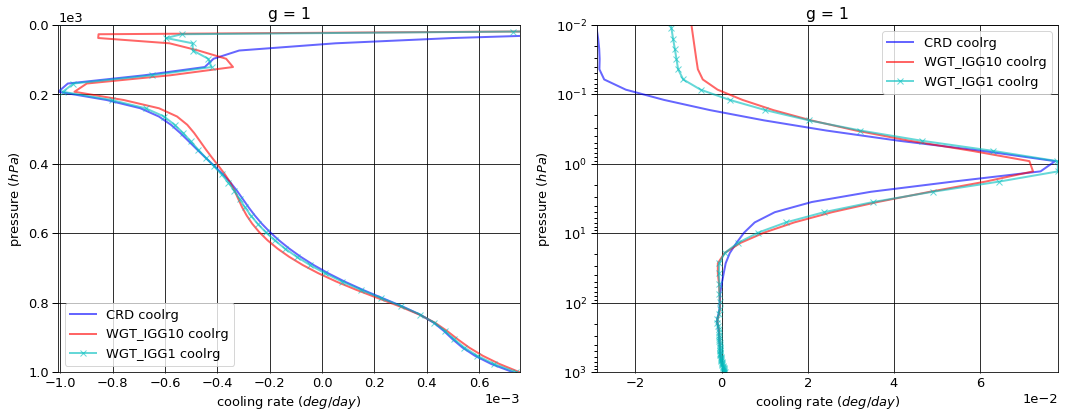

# Figure: cooling rate g-group 2

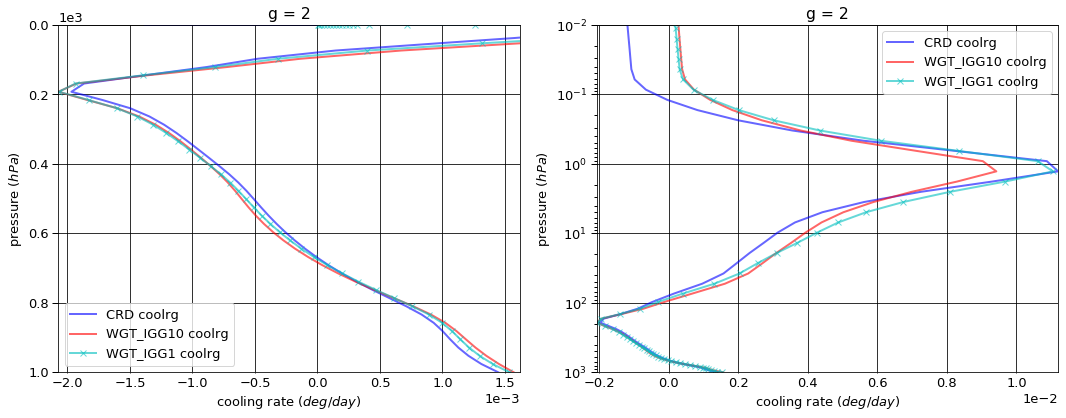

# Figure: cooling rate g-group 3

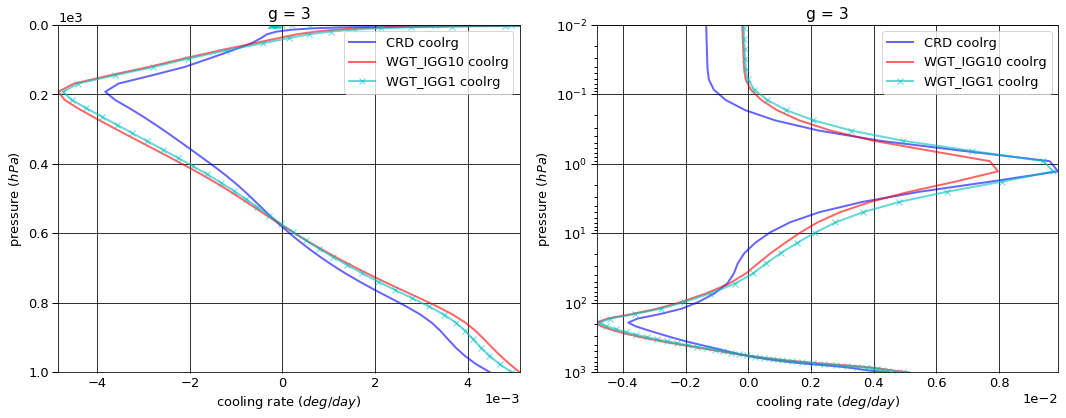

# Figure: cooling rate g-group 4

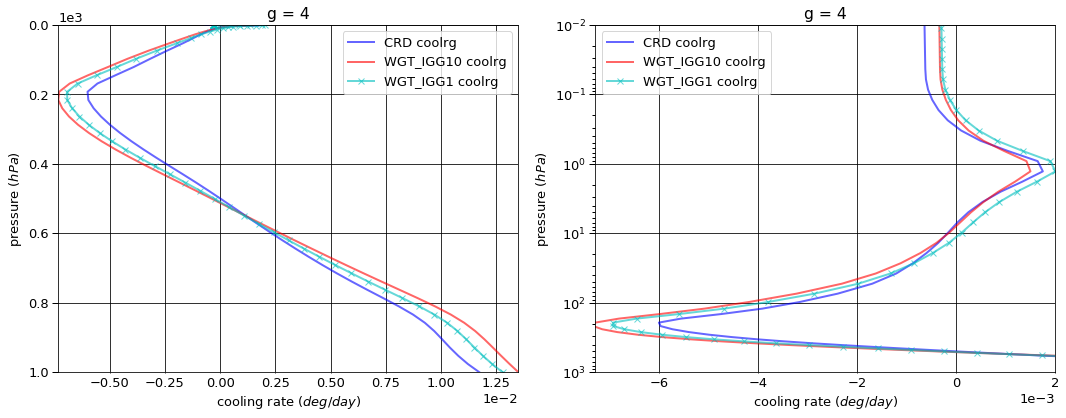

# Figure: cooling rate g-group 5

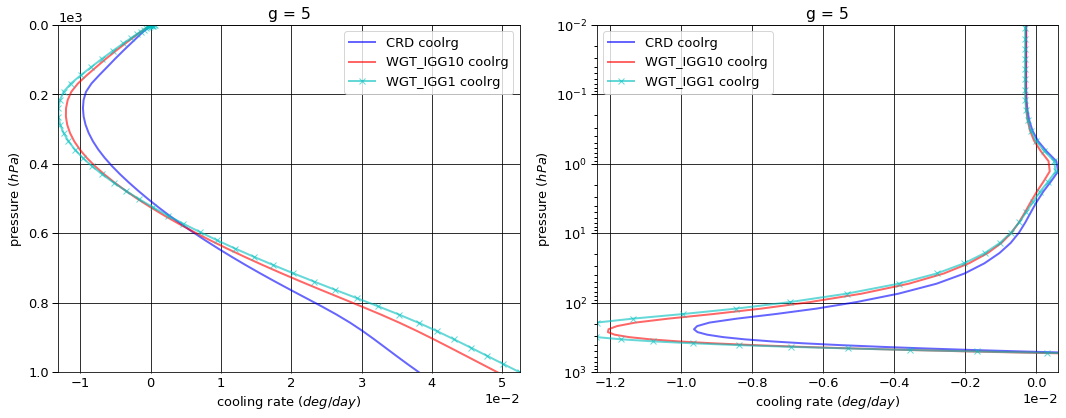

# Figure: cooling rate g-group total

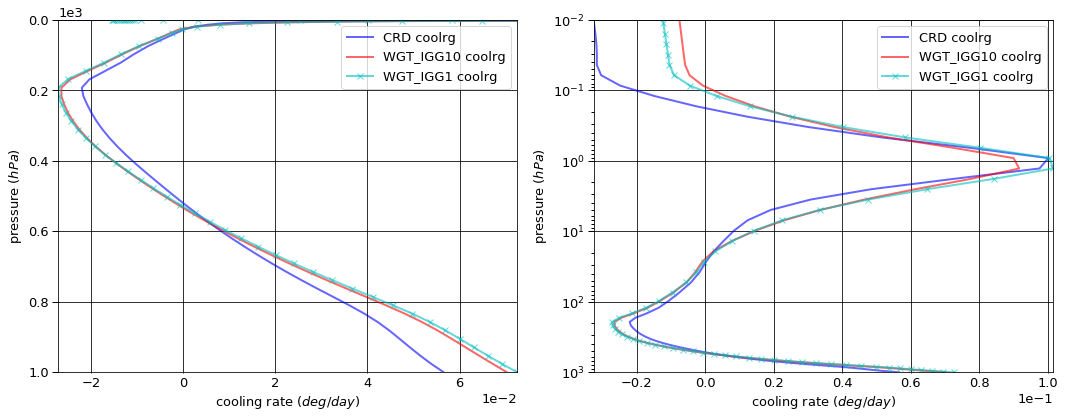

In [20]:
matplotlib.rcParams.update({'font.size': 13,
                            'grid.color': 'black',
                            'axes.facecolor': 'white',
                            'axes.edgecolor': 'black',
                            'ytick.direction': 'out',
                            'ytick.major.size': 6, 'ytick.major.width': 1,
                            'ytick.minor.size': 3, 'ytick.minor.width': 1,
                            'xtick.direction': 'out',
                            'xtick.major.size': 6, 'xtick.major.size': 1,
                            'xtick.minor.size': 3, 'xtick.minor.size': 1}) 

fig.plot(analysis)


In [21]:
table_fluxg.display_withdiff(analysis, benchmark='crd')
table_coolrg.display_withdiff(analysis, benchmark='crd')
table_flux.display_withdiff(analysis, benchmark='crd')
table_coolr.display_withdiff(analysis, benchmark='crd')

# Table: flux. g-groups 


CRD


flug      fldg      fnetg
g pressure level                                
1 0.0      1      -0.030324  0.000000  -0.030324
  1013.0   76     -0.122575  0.104694  -0.017880
2 0.0      1      -0.041903  0.000000  -0.041903
  1013.0   76     -0.245841  0.192413  -0.053429
3 0.0      1      -0.244802  0.000000  -0.244802
  1013.0   76     -0.734903  0.492431  -0.242473
4 0.0      1      -0.977242  0.000000  -0.977242
  1013.0   76     -1.793199  0.999372  -0.793827
5 0.0      1     -19.578900  0.000000 -19.578900
  1013.0   76    -20.858657  2.088358 -18.770299


WGT_IGG10


flug      fldg      fnetg
g pressure level                                
1 0.0      1      -0.034391  0.000000  -0.034391
  1013.0   76     -0.123232  0.107941  -0.015291
2 0.0      1      -0.033504  0.000000  -0.033504
  1013.0   76     -0.247334  0.207498  -0.039836
3 0.0      1      -0.183170  0.000000  -0.183170
  1013.0   76     -0.738028  0.547941  -0.190087
4 0.0      1      -0.935954  0.000000  -0.935954
  1013.0   76     -1.802699  1.059923  -0.742775
5 0.0      1     -19.442875  0.000000 -19.442875
  1013.0   76    -20.843883  2.364782 -18.479101


WGT_IGG1


flug      fldg      fnetg
g pressure level                                
1 0.0      1      -0.034377  0.000000  -0.034377
  1013.0   76     -0.123232  0.106423  -0.016808
2 0.0      1      -0.035736  0.000000  -0.035736
  1013.0   76     -0.247334  0.203865  -0.043469
3 0.0      1      -0.199817  0.000000  -0.199817
  1013.0   76     -0.738028  0.534411  -0.203617
4 0.0      1      -0.947496  0.000000  -0.947496
  1013.0   76     -1.802699  1.038589  -0.764110
5 0.0      1     -19.273750  0.000000 -19.273750
  1013.0   76    -20.843883  2.611956 -18.231926


WGT_IGG10 - CRD


flug      fldg     fnetg
g pressure level                              
1 0.0      1     -0.004067  0.000000 -0.004067
  1013.0   76    -0.000657  0.003246  0.002589
2 0.0      1      0.008399  0.000000  0.008399
  1013.0   76    -0.001492  0.015085  0.013593
3 0.0      1      0.061632  0.000000  0.061632
  1013.0   76    -0.003125  0.055510  0.052385
4 0.0      1      0.041288  0.000000  0.041288
  1013.0   76    -0.009500  0.060552  0.051051
5 0.0      1      0.136025  0.000000  0.136025
  1013.0   76     0.014774  0.276424  0.291198


WGT_IGG1 - CRD


flug      fldg     fnetg
g pressure level                              
1 0.0      1     -0.004053  0.000000 -0.004053
  1013.0   76    -0.000657  0.001729  0.001072
2 0.0      1      0.006167  0.000000  0.006167
  1013.0   76    -0.001492  0.011452  0.009960
3 0.0      1      0.044985  0.000000  0.044985
  1013.0   76    -0.003125  0.041981  0.038856
4 0.0      1      0.029745  0.000000  0.029745
  1013.0   76    -0.009500  0.039217  0.029717
5 0.0      1      0.305150  0.000000  0.305150
  1013.0   76     0.014774  0.523599  0.538373

# Table: cooling rate. g-groups 


CRD


coolrg
g pressure    layer          
1 0.000312    1     -0.033323
  1001.112500 75     0.000730
2 0.000312    1     -0.001381
  1001.112500 75     0.001446
3 0.000312    1     -0.001385
  1001.112500 75     0.004479
4 0.000312    1     -0.000660
  1001.112500 75     0.011740
5 0.000312    1     -0.000272
  1001.112500 75     0.038179


WGT_IGG10


coolrg
g pressure    layer          
1 0.000312    1     -0.009491
  1001.112500 75     0.000756
2 0.000312    1      0.000118
  1001.112500 75     0.001570
3 0.000312    1     -0.000274
  1001.112500 75     0.005124
4 0.000312    1     -0.000358
  1001.112500 75     0.013509
5 0.000312    1     -0.000279
  1001.112500 75     0.049356


WGT_IGG1


coolrg
g pressure    layer          
1 0.000312    1     -0.014641
  1001.112500 75     0.000742
2 0.000312    1      0.000002
  1001.112500 75     0.001535
3 0.000312    1     -0.000256
  1001.112500 75     0.004948
4 0.000312    1     -0.000324
  1001.112500 75     0.012789
5 0.000312    1     -0.000304
  1001.112500 75     0.052527


WGT_IGG10 - CRD


coolrg
g pressure    layer          
1 0.000312    1      0.023833
  1001.112500 75     0.000025
2 0.000312    1      0.001499
  1001.112500 75     0.000124
3 0.000312    1      0.001110
  1001.112500 75     0.000644
4 0.000312    1      0.000302
  1001.112500 75     0.001769
5 0.000312    1     -0.000007
  1001.112500 75     0.011177


WGT_IGG1 - CRD


coolrg
g pressure    layer          
1 0.000312    1      0.018682
  1001.112500 75     0.000012
2 0.000312    1      0.001382
  1001.112500 75     0.000089
3 0.000312    1      0.001129
  1001.112500 75     0.000469
4 0.000312    1      0.000336
  1001.112500 75     0.001050
5 0.000312    1     -0.000032
  1001.112500 75     0.014348

# Table: flux. g-groups total


CRD


,,flug,fldg,fnetg
pressure,level,,,
0.0,1,-20.873171,0.000000,-20.873171
1013.0,76,-23.755175,3.877268,-19.877907



WGT_IGG10


,,flug,fldg,fnetg
pressure,level,,,
0.0,1,-20.629894,0.000000,-20.629894
1013.0,76,-23.755176,4.288085,-19.467091



WGT_IGG1


,,flug,fldg,fnetg
pressure,level,,,
0.0,1,-20.491177,0.000000,-20.491177
1013.0,76,-23.755176,4.495245,-19.259930



WGT_IGG10 - CRD


,,flug,fldg,fnetg
pressure,level,,,
0.0,1,2.432766e-01,0.000000,0.243277
1013.0,76,-6.600000e-07,0.410817,0.410816



WGT_IGG1 - CRD


,,flug,fldg,fnetg
pressure,level,,,
0.0,1,3.819938e-01,0.000000,0.381994
1013.0,76,-6.600000e-07,0.617977,0.617977


# Table: cooling rate. g-groups total


CRD


,,coolrg
pressure,layer,
0.000312,1,-0.037020
1001.112500,75,0.056574



WGT_IGG10


,,coolrg
pressure,layer,
0.000312,1,-0.010283
1001.112500,75,0.070314



WGT_IGG1


,,coolrg
pressure,layer,
0.000312,1,-0.015523
1001.112500,75,0.072541



WGT_IGG10 - CRD


,,coolrg
pressure,layer,
0.000312,1,0.026737
1001.112500,75,0.013740



WGT_IGG1 - CRD


,,coolrg
pressure,layer,
0.000312,1,0.021497
1001.112500,75,0.015967


In [22]:
table_dgdgs.display_dgdgs(crd)

# Table: dgdgs. g-groups 

,dg,dgs
g,,
1,0.005024,0.005188
2,0.010061,0.010412
3,0.030242,0.031068
4,0.073576,0.075887
5,0.881097,0.877446


In [23]:
# read and display overall absth
display.display(
    display.HTML(climahtml.getHTML_idanchor(s_abscom)))
display.display(
    display.Markdown(climahtml.getMarkdown_sectitle(s_abscom)))

display.display(pd.read_csv(os.path.join(crd.rundir, 'abscom.dat'),
                sep=r'\s+',
                index_col=[0]))

# Overall absth

,abscom
g,
1,2.806323e-18
2,5.592068e-19
3,1.114313e-19
4,2.220456e-20
5,2.167990e-27


In [24]:
def spreadsheet(ng_refs, p_refs):
    ng = crd.data['dgdgs'].dims['g']
    
    df_abscom = pd.read_csv(os.path.join(crd.rundir, 'abscom.dat'), 
                            sep=r'\s+', index_col=[0])
    
    # absth(g + 1) / absth(g)
    df_abscom_copy = df_abscom.copy()
    df_abscom_copy.index = df_abscom.index + 1
    df_absratio = df_abscom / df_abscom_copy
    df_absratio.columns = ['k(ig) / k(ig - 1)']
    df_absratio = df_absratio.loc[: ng]
    df_dgdgs = crd.data['dgdgs'].to_dataframe()
    
    
    df_dgdgs_cumsum = df_dgdgs.cumsum(axis=0)
    df_dgdgs_cumsum.columns = ['dg cumsum', 'dgs cumsum']
    
    data_pref = np.concatenate([p_ref * np.ones((ng_ref,)) 
                                for ng_ref, p_ref 
                                in zip(ng_refs, p_refs)], axis=0)
    df_pref = pd.DataFrame(data_pref, 
                           index=df_dgdgs.index, columns=['pref'])
    
    df_all = pd.concat([df_abscom, df_absratio,
                        df_dgdgs, df_dgdgs_cumsum,
                        df_pref], axis=1) 
    return df_all
    

In [25]:
display.display(display.HTML(climahtml.getHTML_idanchor(s_ggroup_summary)))
display.display(display.Markdown(climahtml.getMarkdown_sectitle(s_ggroup_summary)))
display.display(spreadsheet(NG_REFS, P_REFS))

# g-group summary

,abscom,k(ig) / k(ig - 1),dg,dgs,dg cumsum,dgs cumsum,pref
g,,,,,,,
1,2.806323e-18,NaN,0.005024,0.005188,0.005024,0.005188,50.0
2,5.592068e-19,1.992668e-01,0.010061,0.010412,0.015085,0.015599,50.0
3,1.114313e-19,1.992668e-01,0.030242,0.031068,0.045327,0.046667,50.0
4,2.220456e-20,1.992668e-01,0.073576,0.075887,0.118903,0.122554,50.0
5,2.167990e-27,9.763717e-08,0.881097,0.877446,1.000000,1.000000,50.0


In [26]:
def load_d_bigsum():
    
    ng = 10
    
    fpath = os.path.join(crd.rundir, 'd_bigsum.dat')
    df = pd.read_csv(fpath, sep=r'\s+', index_col = [0, 1])

    g_layers = [(1, 62), (2, 58)]
    
    writer = pd.ExcelWriter('_'.join(['d_bigsum_absgas',
                                      'ng_{}'.format(ng)])
                            + '.xlsx')
    for g, layer in g_layers:
        df.loc[(g, layer), :].to_excel(writer, 
                                       '({}, {})'.format(g, layer))
        

#load_d_bigsum()

In [27]:
display.HTML('''<script>
code_show=true; 
function code_toggle() {
 if (code_show){
 $('div.input').hide();
 } else {
 $('div.input').show();
 }
 code_show = !code_show
} 
$( document ).ready(code_toggle);
</script>
<form action="javascript:code_toggle()"><input type="submit" value="Click here to toggle on/off the raw code."></form>''')
